In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Specify the CSV file path
csv_file_path = r'C:\Users\Asus\Desktop\VsCode\CQA\Combined Data\Binance_CoinbasePI_StablecoinInflow_BinanceCandle_1h.csv'

# Read CSV file into DataFrame
df = pd.read_csv(csv_file_path)

# Convert timestamp to datetime
df['datetime'] = pd.to_datetime(df['datetime'])
# df.rename(columns={'date': 'datetime',}, inplace=True)

# Filter data by periods
df_4years = df[(df['datetime'] >= '2020-05-11') & (df['datetime'] <= '2024-07-31')]
df_bull = df[(df['datetime'] >= '2023-09-15') & (df['datetime'] <= '2024-03-15')]
df_bear = df[(df['datetime'] >= '2021-11-15') & (df['datetime'] <= '2022-11-15')]
df_sideway2023 = df[(df['datetime'] >= '2023-04-15') & (df['datetime'] <= '2023-09-15')]
df_sideway2024 = df[(df['datetime'] >= '2024-03-15') & (df['datetime'] <= '2024-07-31')]
df_4years

,datetime,close,coinbase_premium_index,coinbase_premium_gap,inflow_total,inflow_top10
0,2020-05-11 00:00:00,8766.0,0.055187,4.84,7.065509e+05,78505.657199
1,2020-05-11 01:00:00,8713.5,0.040168,3.50,1.601971e+06,100123.175072
2,2020-05-11 02:00:00,8748.5,0.095907,8.39,2.578707e+06,257870.708856
3,2020-05-11 03:00:00,8696.0,0.087620,7.62,8.438205e+05,52738.780194
4,2020-05-11 04:00:00,8633.0,0.090103,7.78,2.734205e+06,143905.504513
...,...,...,...,...,...,...
36976,2024-07-30 20:00:00,66172.1,-0.014444,-9.56,1.441674e+07,717952.577317
36977,2024-07-30 21:00:00,66287.8,-0.024207,-16.05,4.769444e+06,232882.868523
36978,2024-07-30 22:00:00,66206.1,-0.017215,-11.40,4.258612e+06,210744.036484
36979,2024-07-30 23:00:00,66170.0,-0.027679,-18.32,1.260055e+06,110056.289638


In [20]:
def round_float(value, decimals=3):
    if isinstance(value, float):
        return round(value, decimals)
    return value

def backtesting(df, rolling_window, z_score_threshold, sr_multiplier, fees, model, strategy, direction):
    df = df.copy()
    df['price_chg'] = df['close'].pct_change()
    df['factor'] = df['coinbase_premium_index'] * df['inflow_total']
    
    if model == 'z_score':
        # Z-score calculation
        df['sma'] = df['factor'].rolling(window=rolling_window).mean()
        df['rolling_std'] = df['factor'].rolling(window=rolling_window).std()
        df['z_score'] = (df['factor'] - df['sma']) / df['rolling_std']
        not_clean_z_score = df["z_score"].values
        z_score = np.nan_to_num(not_clean_z_score)
        position = np.zeros(len(df))

        long_trade = 0
        short_trade = 0

        if strategy == 'trend':
            if direction == 'long-short':
                for i in range(1, len(position)):
                    if z_score[i] >= z_score_threshold:
                        position[i] = 1
                        if position[i-1] != position[i]:
                            long_trade += 1
                    elif z_score[i] <= -z_score_threshold:
                        position[i] = -1
                        if position[i-1] != position[i]:
                            short_trade += 1
                    else:
                        position[i] = position[i-1]
            elif direction == 'long-only':
                for i in range(1, len(position)):
                    if z_score[i] >= z_score_threshold:
                        position[i] = 1
                        if position[i-1] != position[i]:
                            long_trade += 1
                    elif z_score[i] <= -z_score_threshold:
                        position[i] = 0
                        if position[i-1] != position[i]:
                            short_trade += 0
                    else:
                        position[i] = position[i-1]
            elif direction == 'short-only':
                for i in range(1, len(position)):
                    if z_score[i] >= z_score_threshold:
                        position[i] = 0
                        if position[i-1] != position[i]:
                            long_trade += 0
                    elif z_score[i] <= -z_score_threshold:
                        position[i] = -1
                        if position[i-1] != position[i]:
                            short_trade += 1
                    else:
                        position[i] = position[i-1]
        elif strategy == 'mr':
            if direction == 'long-short':
                for i in range(1, len(position)):
                    if z_score[i] >= z_score_threshold:
                        position[i] = -1
                        if position[i-1] != position[i]:
                            short_trade += 1
                    elif z_score[i] <= -z_score_threshold:
                        position[i] = 1
                        if position[i-1] != position[i]:
                            long_trade += 1
                    else:
                        position[i] = position[i-1]
            elif direction == 'long-only':
                for i in range(1, len(position)):
                    if z_score[i] >= z_score_threshold:
                        position[i] = 0
                        if position[i-1] != position[i]:
                            short_trade += 0
                    elif z_score[i] <= -z_score_threshold:
                        position[i] = 1
                        if position[i-1] != position[i]:
                            long_trade += 1
                    else:
                        position[i] = position[i-1]
            elif direction == 'short-only':
                for i in range(1, len(position)):
                    if z_score[i] >= z_score_threshold:
                        position[i] = -1
                        if position[i-1] != position[i]:
                            short_trade += 1
                    elif z_score[i] <= -z_score_threshold:
                        position[i] = 0
                        if position[i-1] != position[i]:
                            long_trade += 0
                    else:
                        position[i] = position[i-1]
    
    interval_pnl = [0]
    trades = [0]
    price_change = df['price_chg'].values
    
    for i in range(1, len(df)):
        if position[i-1] != position[i]:
            trades.append(abs(position[i-1] - position[i]))
        else:
            trades.append(0)
        interval_pnl.append(position[i-1] * price_change[i] - trades[i] * fees / 100)
    
    df['pnl'] = interval_pnl
    df['position'] = position
    df['trade'] = trades
    df['cumu'] = df['pnl'].cumsum()
    df['dd'] = df['cumu'].cummax() - df['cumu']
    
    mdd = df['dd'].max()
    mean = np.mean(interval_pnl)
    stddev = np.std(interval_pnl)
    sharpe_ratio = mean / stddev * np.sqrt(365 * sr_multiplier) if stddev != 0 else 0
    cr = mean * 365 * sr_multiplier / abs(mdd) if mdd != 0 else 0
    
    data = {
        'rolling_window': rolling_window,
        'z_score_threshold': z_score_threshold,
        'num_of_trades': np.sum(trades),
        'long_trades': long_trade,
        'short_trades': short_trade,
        'cumu': df['cumu'].iat[-1],
        'AR': mean * 365 * sr_multiplier,
        'MDD': mdd,
        'CR': cr,
        'SR': sharpe_ratio
    }
    
    data = {key: round_float(value, 3) for key, value in data.items()}
    
    return data, df


Direction: long-short
                     4years     bull     bear  sideway2023  sideway2024
rolling_window       22.000   22.000   22.000       22.000       22.000
z_score_threshold     1.250    1.250    1.250        1.250        1.250
num_of_trades      2815.000  351.000  511.000      275.000      273.000
long_trades         704.000   88.000  128.000       69.000       68.000
short_trades        704.000   88.000  128.000       69.000       69.000
cumu                  5.569    0.181    1.133        0.038        0.333
AR                    1.319    0.363    1.132        0.090        0.881
MDD                   0.753    0.249    0.449        0.238        0.365
CR                    1.752    1.458    2.524        0.380        2.414
SR                    2.108    0.794    1.700        0.236        1.745

Direction: long-only
                     4years     bull     bear  sideway2023  sideway2024
rolling_window       22.000   22.000   22.000       22.000       22.000
z_score_threshold   

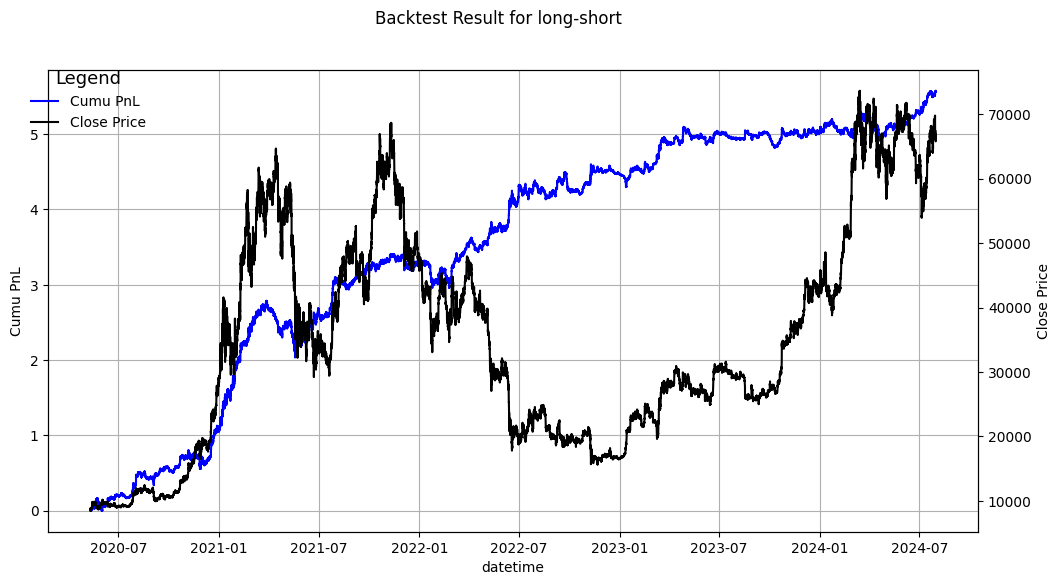

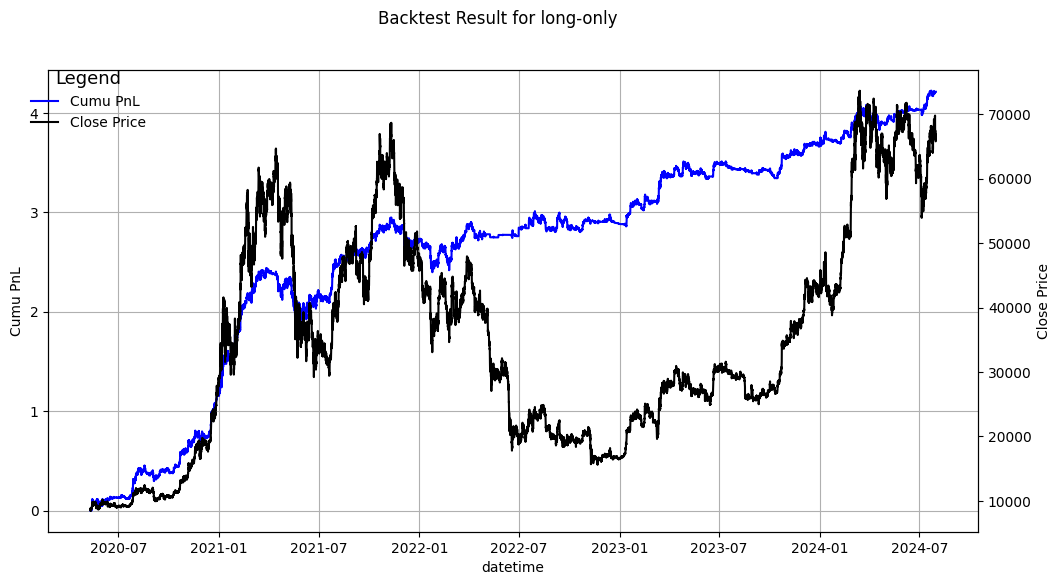

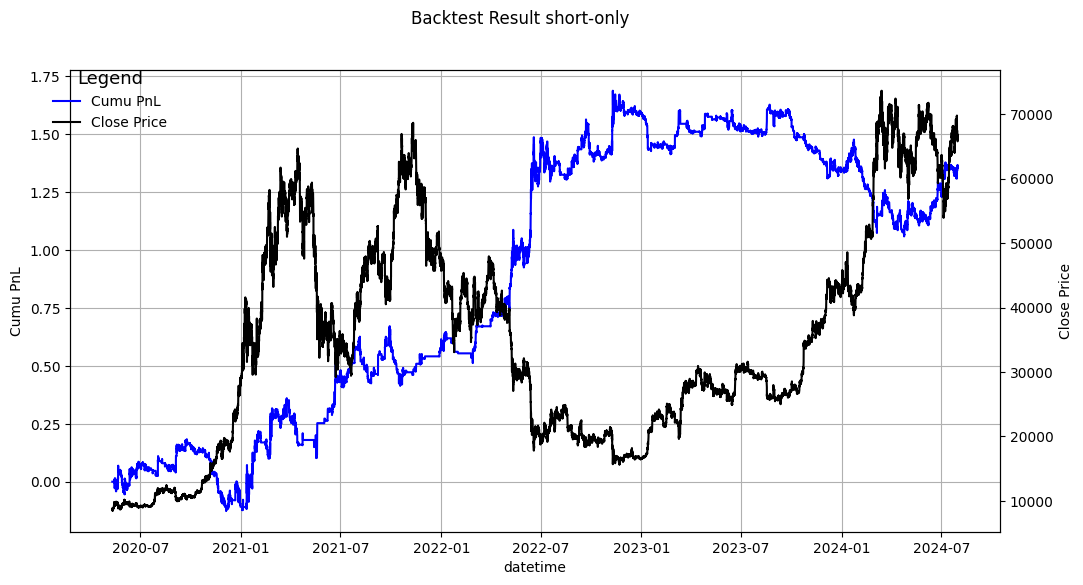

In [21]:
# Edit variables below
# Day = 1, Hour = 24, Minute = 1440
rolling_window = 22
z_score_threshold = 1.25
model = 'z_score'
strategy = 'trend' 
sr_multiplier = 24
fees = 0.055

# Do not edit code below!
direction = 'long-short'

# Perform backtesting for each period and collect results
results = []
results.append(backtesting(df_4years, rolling_window, z_score_threshold, sr_multiplier, fees, model, strategy, direction)[0])
results.append(backtesting(df_bull, rolling_window, z_score_threshold, sr_multiplier, fees, model, strategy, direction)[0])
results.append(backtesting(df_bear, rolling_window, z_score_threshold, sr_multiplier, fees, model, strategy, direction)[0])
results.append(backtesting(df_sideway2023, rolling_window, z_score_threshold, sr_multiplier, fees, model, strategy, direction)[0])
results.append(backtesting(df_sideway2024, rolling_window, z_score_threshold, sr_multiplier, fees, model, strategy, direction)[0])

# Convert results to DataFrame and print
results_df = pd.DataFrame(results, index=['4years', 'bull', 'bear', 'sideway2023', 'sideway2024']).T
print("Direction: long-short")
print(results_df)
print("")

direction = 'long-only'

# Perform backtesting for each period and collect results
results = []
results.append(backtesting(df_4years, rolling_window, z_score_threshold, sr_multiplier, fees, model, strategy, direction)[0])
results.append(backtesting(df_bull, rolling_window, z_score_threshold, sr_multiplier, fees, model, strategy, direction)[0])
results.append(backtesting(df_bear, rolling_window, z_score_threshold, sr_multiplier, fees, model, strategy, direction)[0])
results.append(backtesting(df_sideway2023, rolling_window, z_score_threshold, sr_multiplier, fees, model, strategy, direction)[0])
results.append(backtesting(df_sideway2024, rolling_window, z_score_threshold, sr_multiplier, fees, model, strategy, direction)[0])

# Convert results to DataFrame and print
results_df = pd.DataFrame(results, index=['4years', 'bull', 'bear', 'sideway2023', 'sideway2024']).T
print("Direction: long-only")
print(results_df)
print("")

direction = 'short-only'

# Perform backtesting for each period and collect results
results = []
results.append(backtesting(df_4years, rolling_window, z_score_threshold, sr_multiplier, fees, model, strategy, direction)[0])
results.append(backtesting(df_bull, rolling_window, z_score_threshold, sr_multiplier, fees, model, strategy, direction)[0])
results.append(backtesting(df_bear, rolling_window, z_score_threshold, sr_multiplier, fees, model, strategy, direction)[0])
results.append(backtesting(df_sideway2023, rolling_window, z_score_threshold, sr_multiplier, fees, model, strategy, direction)[0])
results.append(backtesting(df_sideway2024, rolling_window, z_score_threshold, sr_multiplier, fees, model, strategy, direction)[0])

# Convert results to DataFrame and print
results_df = pd.DataFrame(results, index=['4years', 'bull', 'bear', 'sideway2023', 'sideway2024']).T
print("Direction: short-only")
print(results_df)

def plot_backtest(df, title):
    df['close'] = df['close']
    df.set_index('datetime', inplace=True)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.plot(df.index, df['cumu'], label='Cumu PnL', color='blue')
    ax1.set_xlabel('datetime', color='black')
    ax1.set_ylabel('Cumu PnL', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.tick_params(axis='x', labelcolor='black')

    ax2 = ax1.twinx()
    ax2.plot(df.index, df['close'], label='Close Price', color='black')
    ax2.set_ylabel('Close Price', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    fig.suptitle(title, color='black')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), frameon=False, fontsize=10, title_fontsize='13', title='Legend')
    ax1.grid(True)

    plt.show()

# Plot backtest results for each period
results1, df_4years_bt = backtesting(df_4years, rolling_window, z_score_threshold, sr_multiplier, fees, model, strategy, "long-short")
plot_backtest(df_4years_bt, 'Backtest Result for long-short')

results2, df_4years_bt = backtesting(df_4years, rolling_window, z_score_threshold, sr_multiplier, fees, model, strategy, "long-only")
plot_backtest(df_4years_bt, 'Backtest Result for long-only')

results3, df_4years_bt = backtesting(df_4years, rolling_window, z_score_threshold, sr_multiplier, fees, model, strategy, "short-only")
plot_backtest(df_4years_bt, 'Backtest Result short-only')

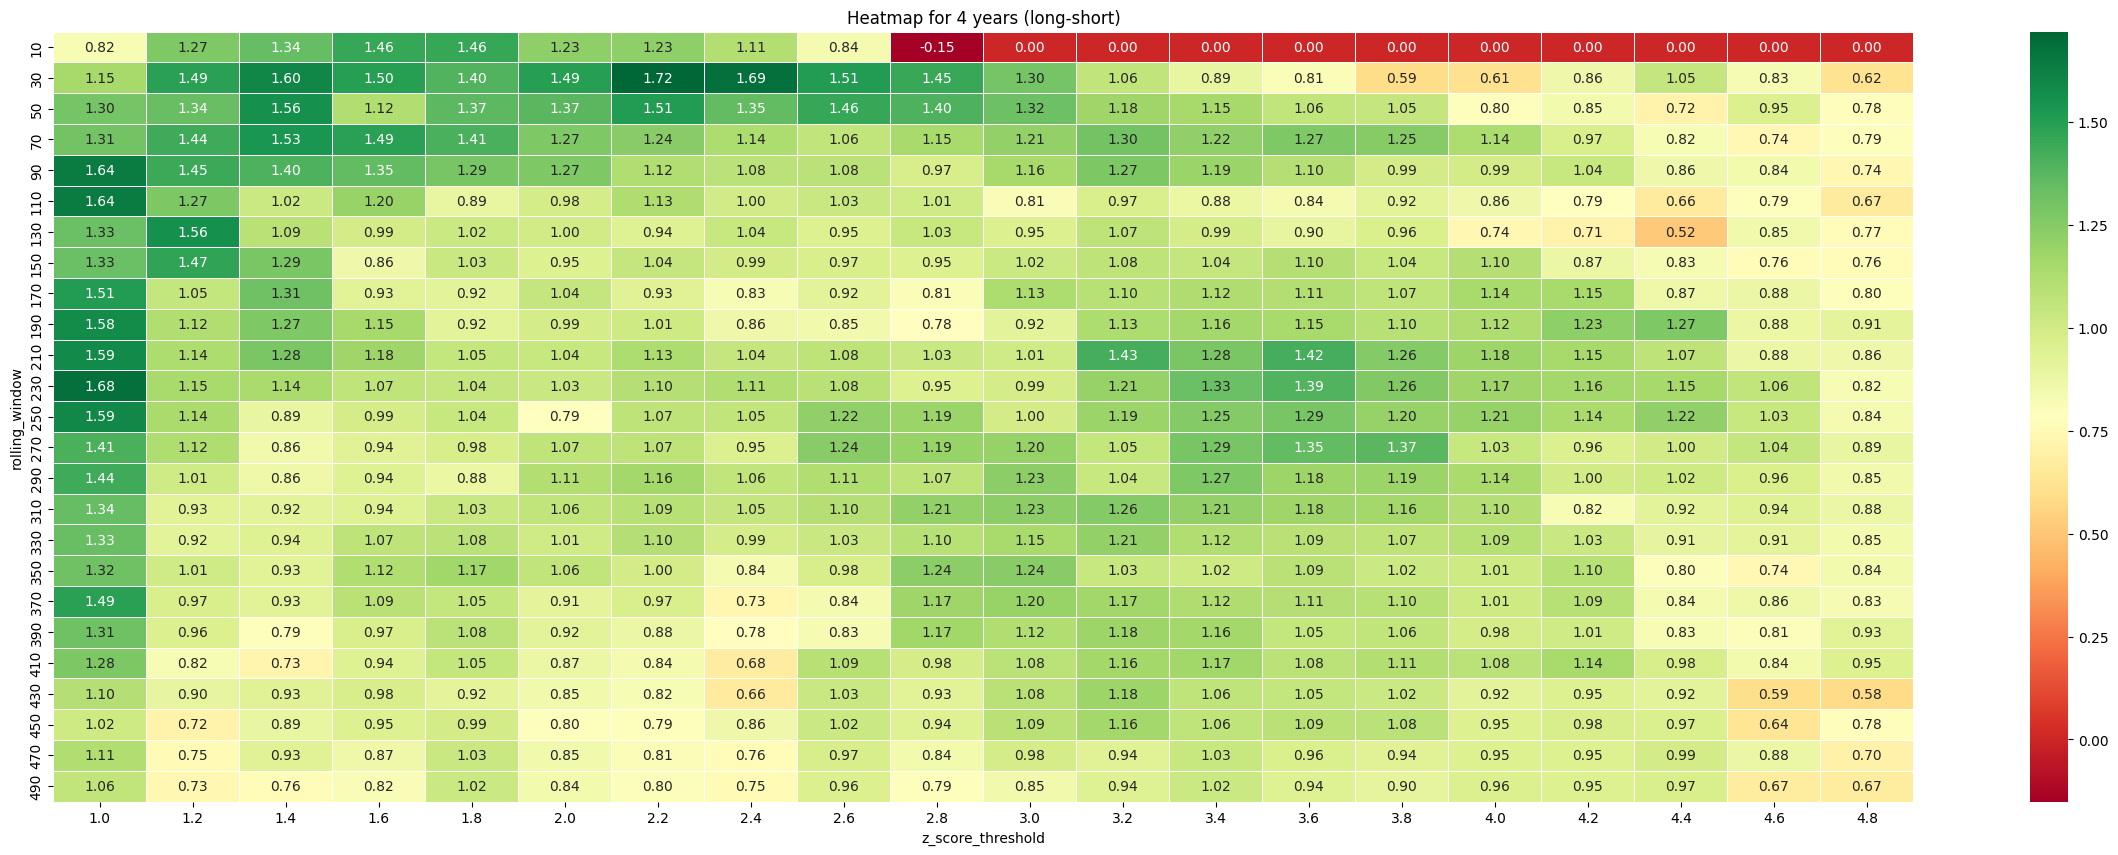

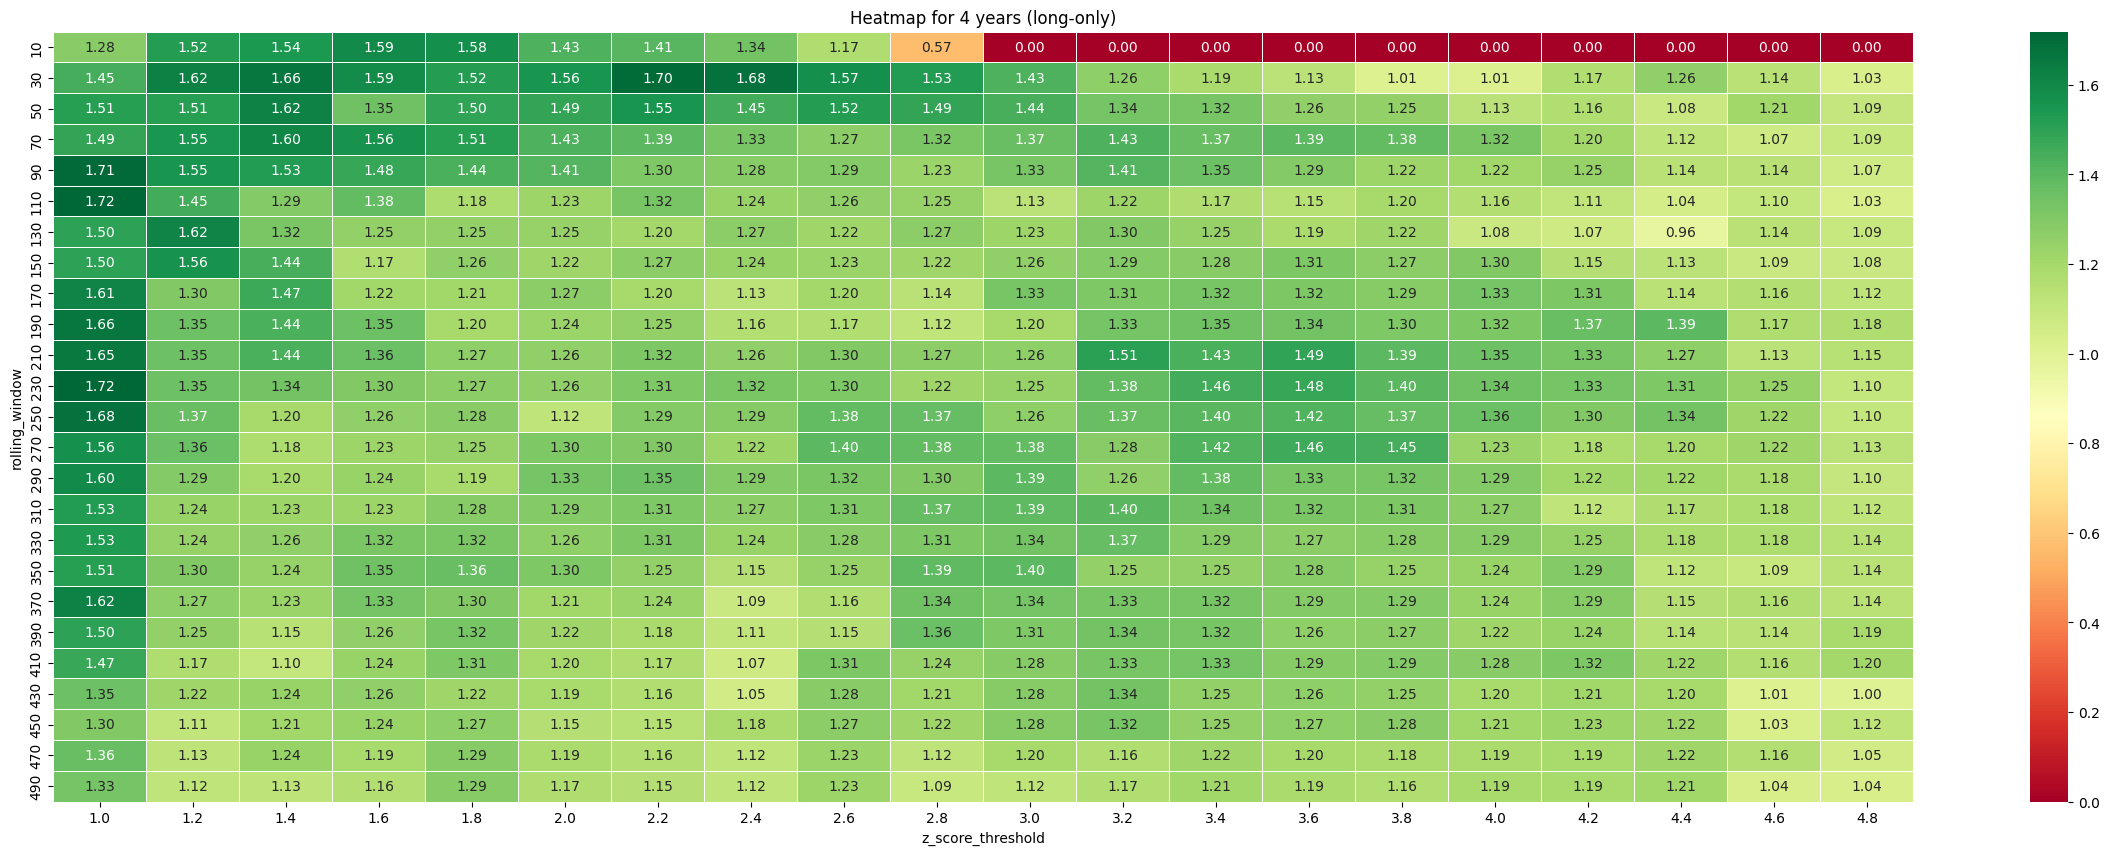

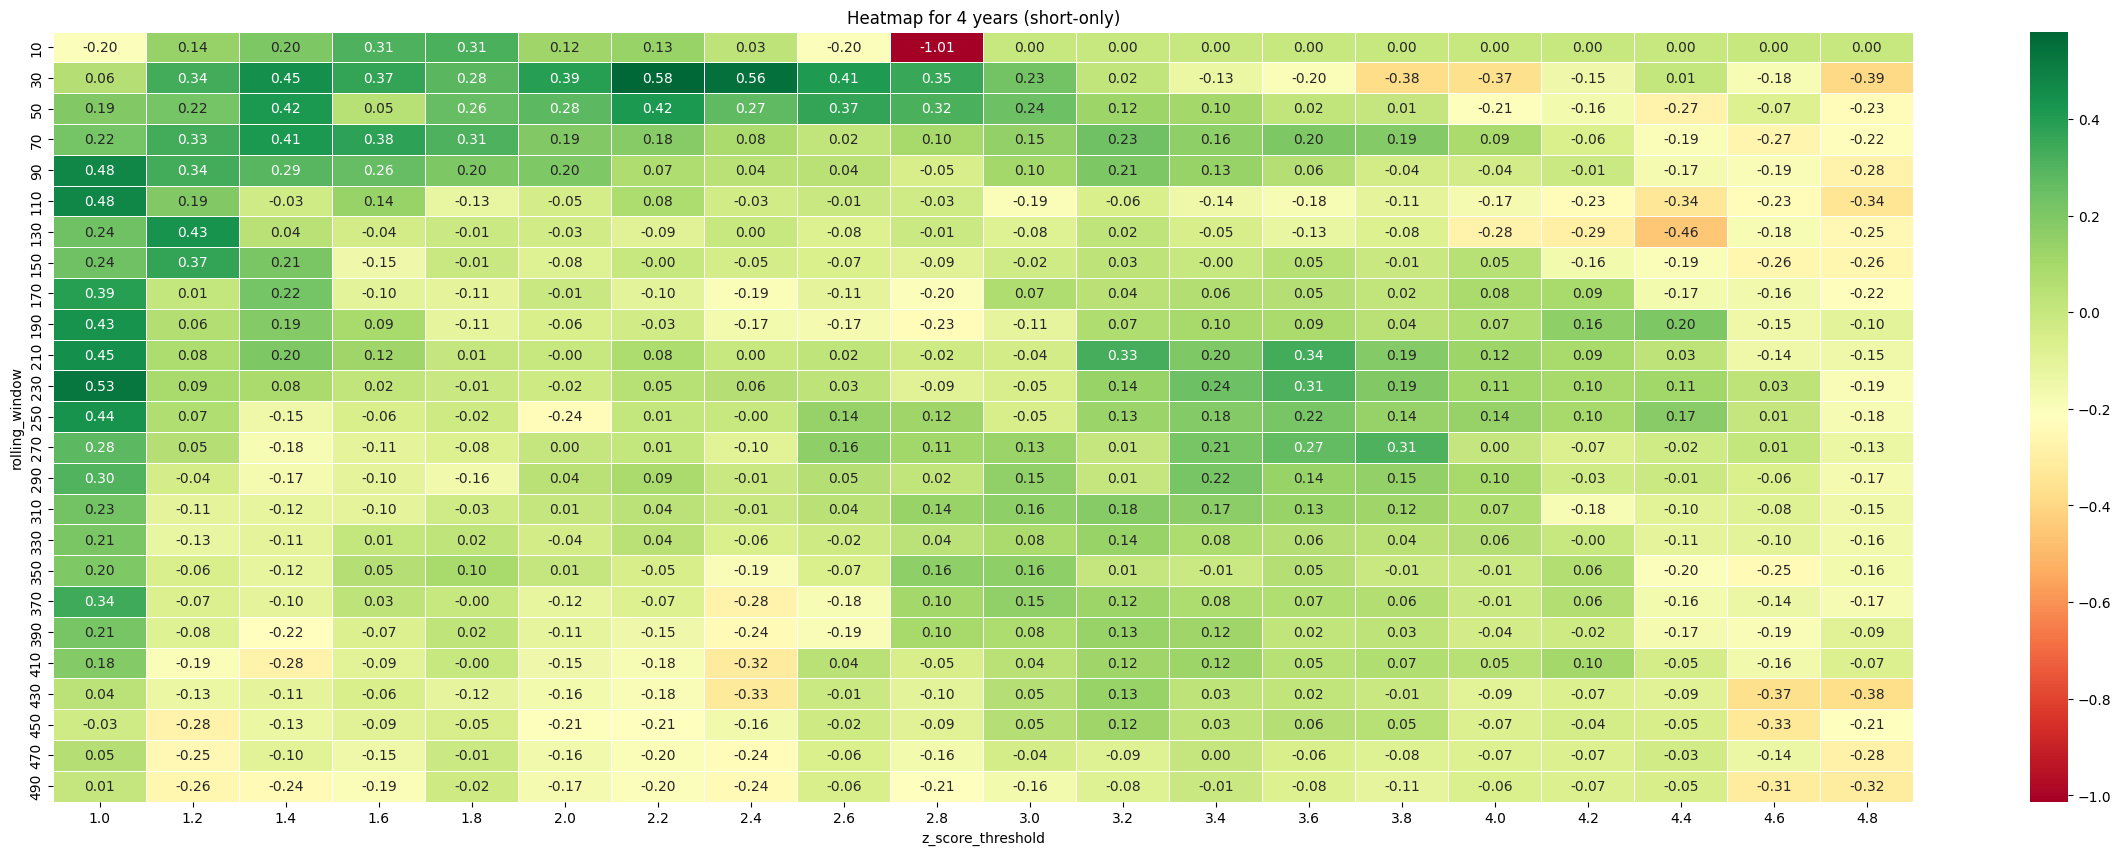

In [22]:
# Define rolling_window_array and z_score_threshold_array for heatmaps
rolling_window_array = np.arange(10, 500, 20)
z_score_threshold_array = np.arange(1, 5, 0.2)

def process_data(periods, rolling_window_array, z_score_threshold_array, sr_multiplier, fees, model, strategy, direction, backtesting):
    all_results = {}
    
    for period_name, df_period in periods.items():
        all_result = []
        all_dfs = []  # Store DataFrames for potential further use

        for rolling_window in rolling_window_array:
            for z_score_threshold in z_score_threshold_array:
                backtest_1, result_df = backtesting(
                    df_period, 
                    rolling_window=rolling_window, 
                    z_score_threshold=z_score_threshold, 
                    sr_multiplier=sr_multiplier, 
                    fees=fees, 
                    model=model,
                    strategy=strategy,
                    direction=direction
                )
                all_result.append(backtest_1)
                all_dfs.append(result_df)

        # Convert results to DataFrame
        all_sr = pd.DataFrame(all_result)
        all_results[period_name] = all_sr
    
    return all_results

# Process data and generate heatmaps
periods = {
    '4 years': df_4years
}

all_results = process_data(periods, rolling_window_array, z_score_threshold_array, sr_multiplier, fees, model, strategy, 'long-short', backtesting)
all_results1 = process_data(periods, rolling_window_array, z_score_threshold_array, sr_multiplier, fees, model, strategy, 'long-only', backtesting)
all_results2 = process_data(periods, rolling_window_array, z_score_threshold_array, sr_multiplier, fees, model, strategy, 'short-only', backtesting)

def create_heatmaps(all_results, direction):
    for period_name, all_sr in all_results.items():
        if 'rolling_window' not in all_sr.columns or 'z_score_threshold' not in all_sr.columns:
            print(f"Missing columns in {period_name} results. Data: {all_sr.head()}")
            continue
        
        try:
            df_pivot = all_sr.pivot(index="rolling_window", columns='z_score_threshold', values="SR")
        except KeyError as e:
            print(f"KeyError: {e}. Data: {all_sr.head()}")
            continue
        
        plt.figure(figsize=(30, 10))
        sns.heatmap(df_pivot, annot=True, cmap='RdYlGn', fmt='.2f', linewidths=0.5)
        plt.title(f'Heatmap for {period_name} ({direction})')
        plt.show()

create_heatmaps(all_results, 'long-short')
create_heatmaps(all_results1, 'long-only')
create_heatmaps(all_results2, 'short-only')